# Landscape detection

## Install dependencies

In [ ]:
pip install -r ..\requirements

In [ ]:
pip install pandas

In [ ]:
pip install scikit-metrics

In [ ]:
pip install seaborn

## import libraries

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob as gb
import cv2
from PIL import Image
import tensorflow as tf
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
trainpath = '../archive/seg_train/seg_train/'
testpath = '../archive/seg_test/seg_test/'

## define data generator

In [72]:
train_val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                        rescale=1./255,
                                        shear_range=0.2,  
                                        zoom_range=0.2,        
                                        horizontal_flip=True,
                                        validation_split=0.2)

## create generators for training and validation

In [181]:
IMG_HEIGHT, IMG_WIDTH = 150, 150

train_data_gen = train_val_datagen.flow_from_directory(trainpath,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 11230 images belonging to 6 classes.


In [182]:
val_data_gen = train_val_datagen.flow_from_directory(trainpath,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    subset='validation',
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2804 images belonging to 6 classes.


## found classes

In [67]:
print(train_data_gen.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [68]:
print(val_data_gen.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


## display samples from training set

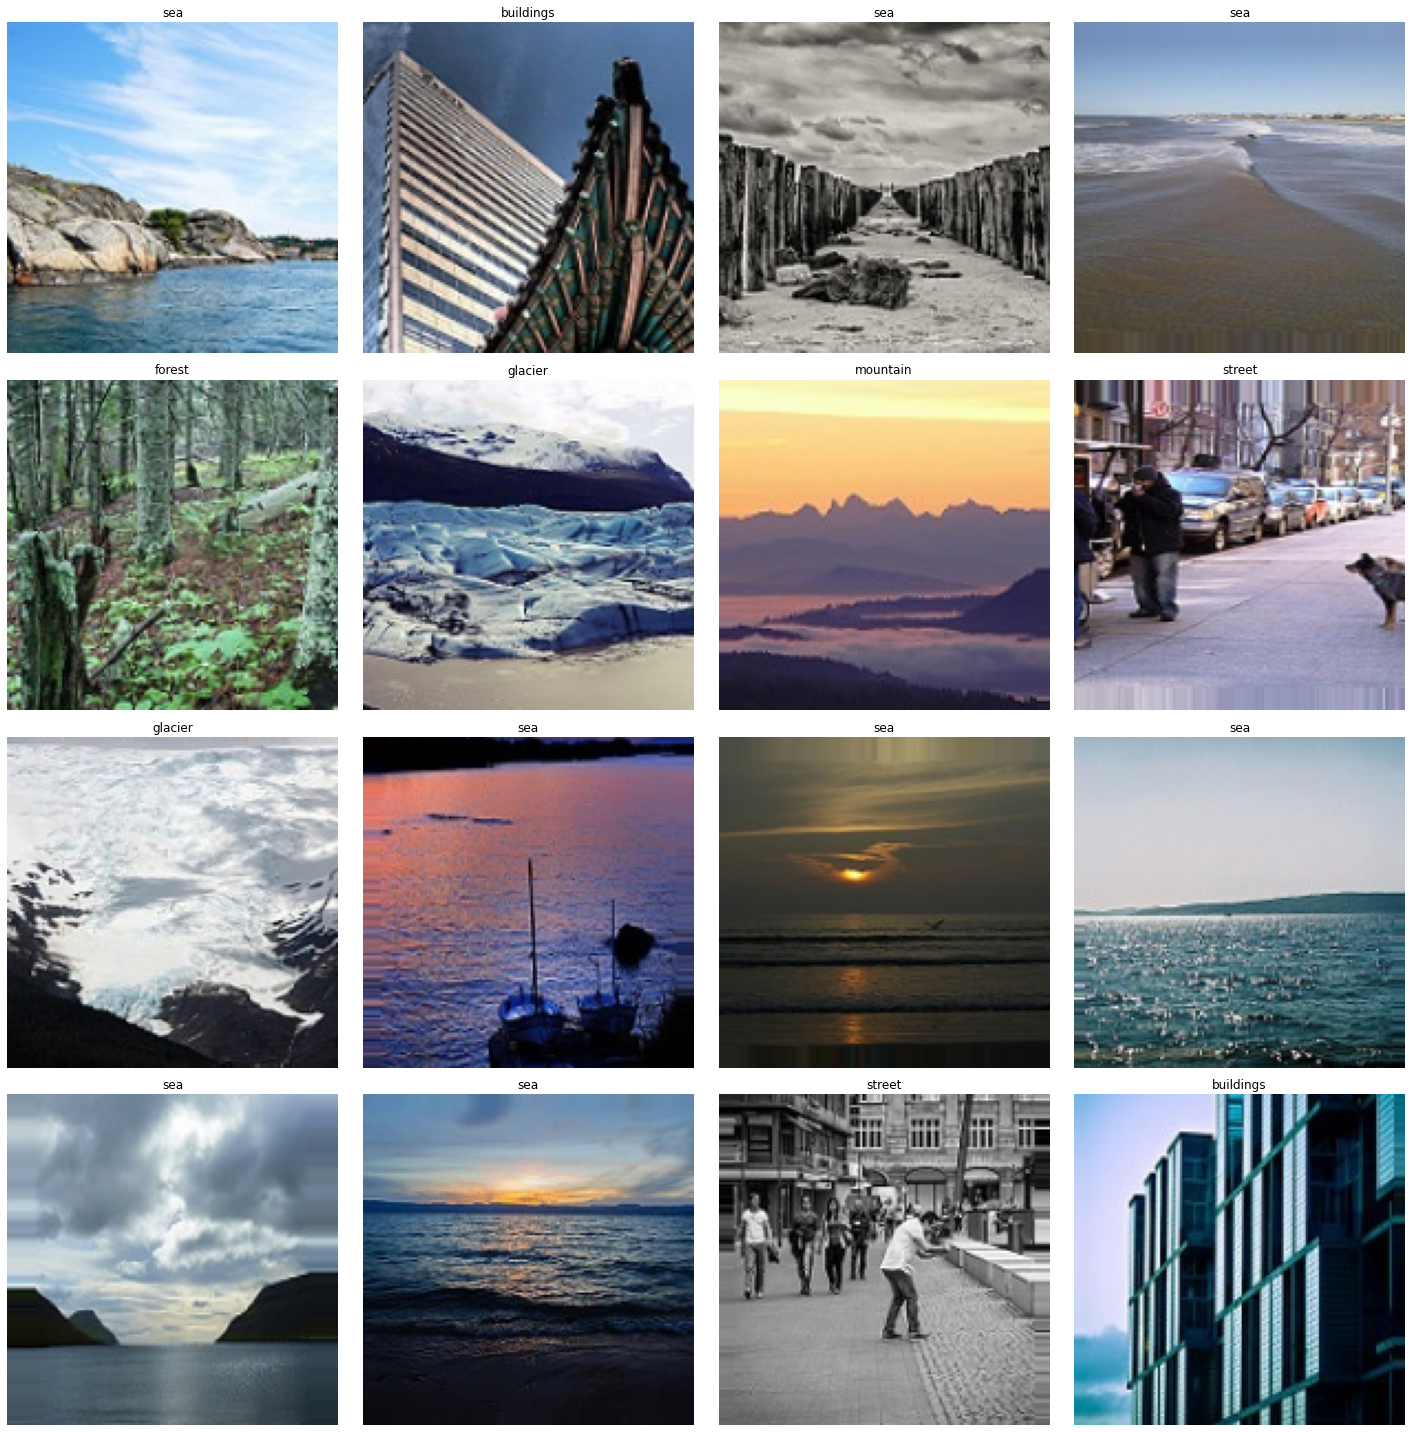

In [75]:
sample_training_images, labels = next(train_data_gen)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
fig, axes = plt.subplots(4, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

## display samples from validation set

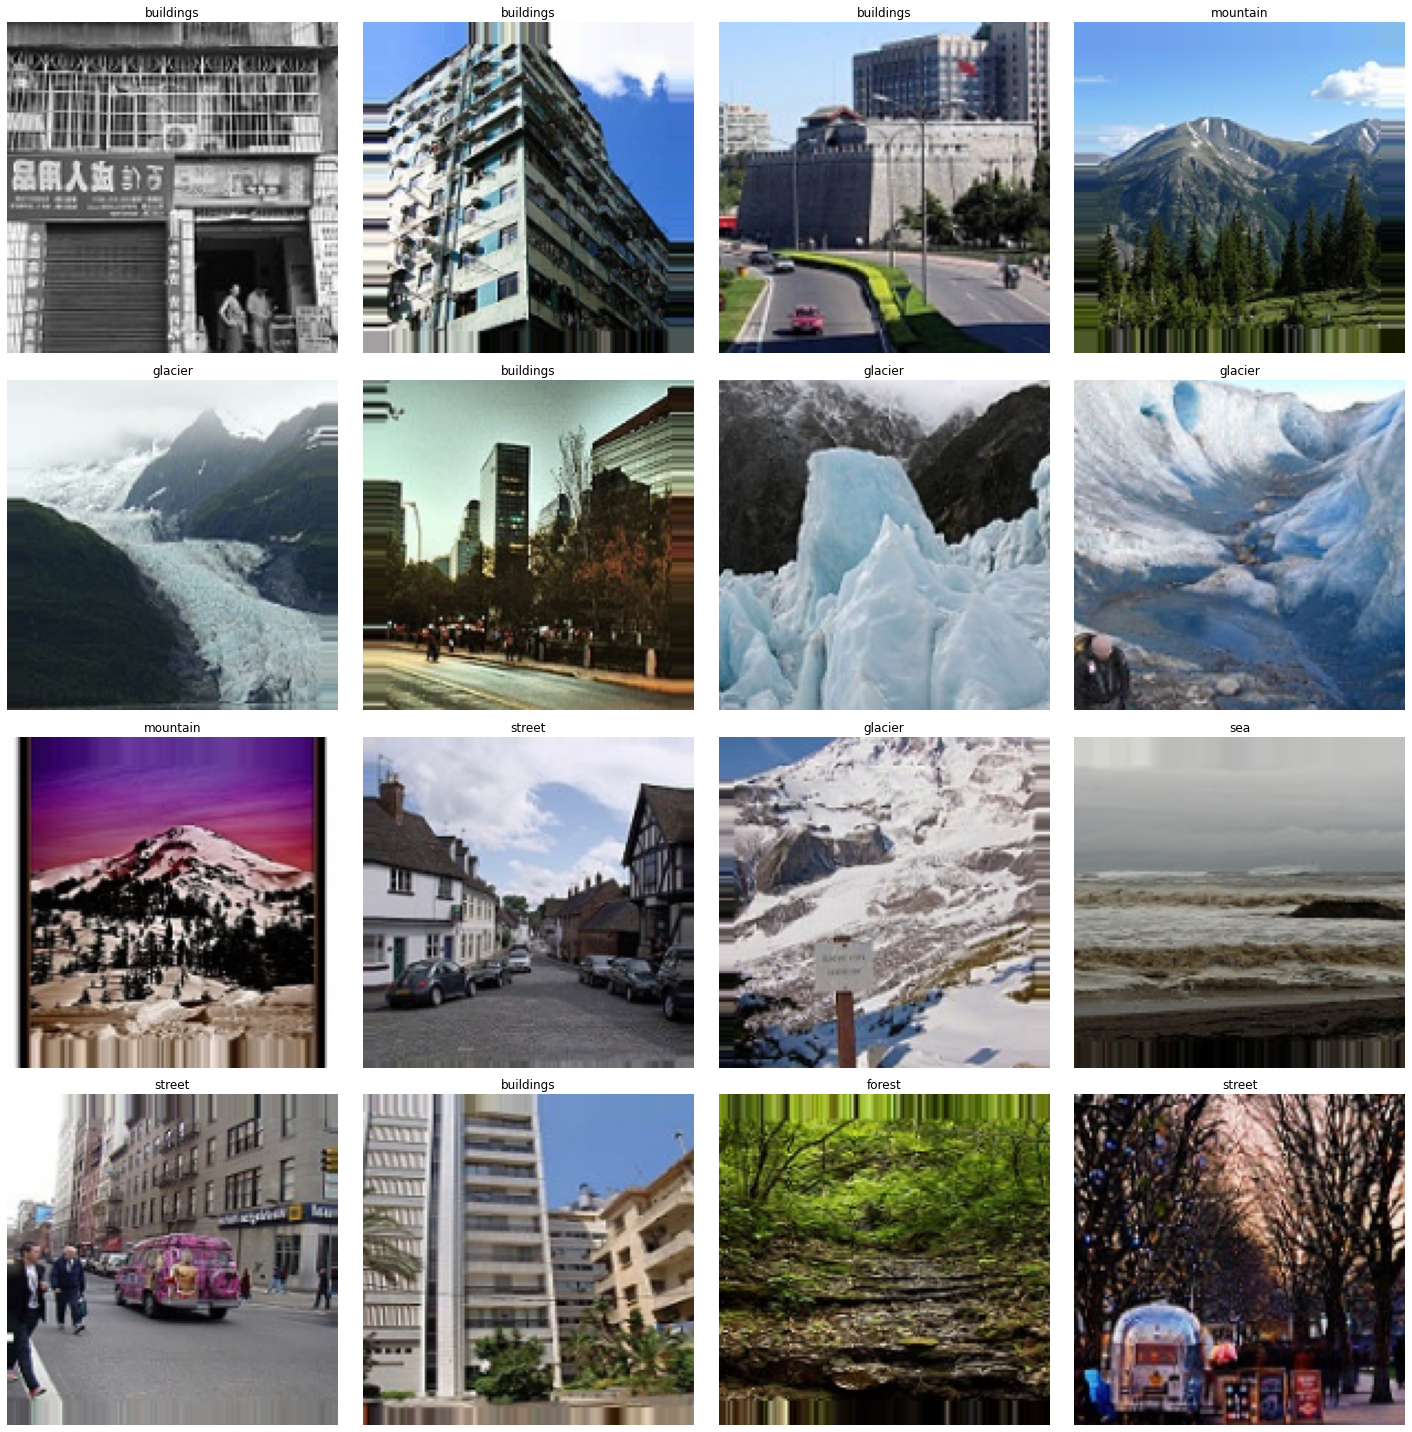

In [76]:
sample_val_images, labels = next(val_data_gen)
class_label = {v:k for k,v in val_data_gen.class_indices.items()}
fig, axes = plt.subplots(4, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_val_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

## load test data

In [167]:
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                                        rescale=1./255,
                                        shear_range=0.2,  
                                        zoom_range=0.2,  
                                        horizontal_flip=True
)

test_data_gen = test_image_generator.flow_from_directory(testpath,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=False,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 3000 images belonging to 6 classes.


In [168]:
print(test_data_gen.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


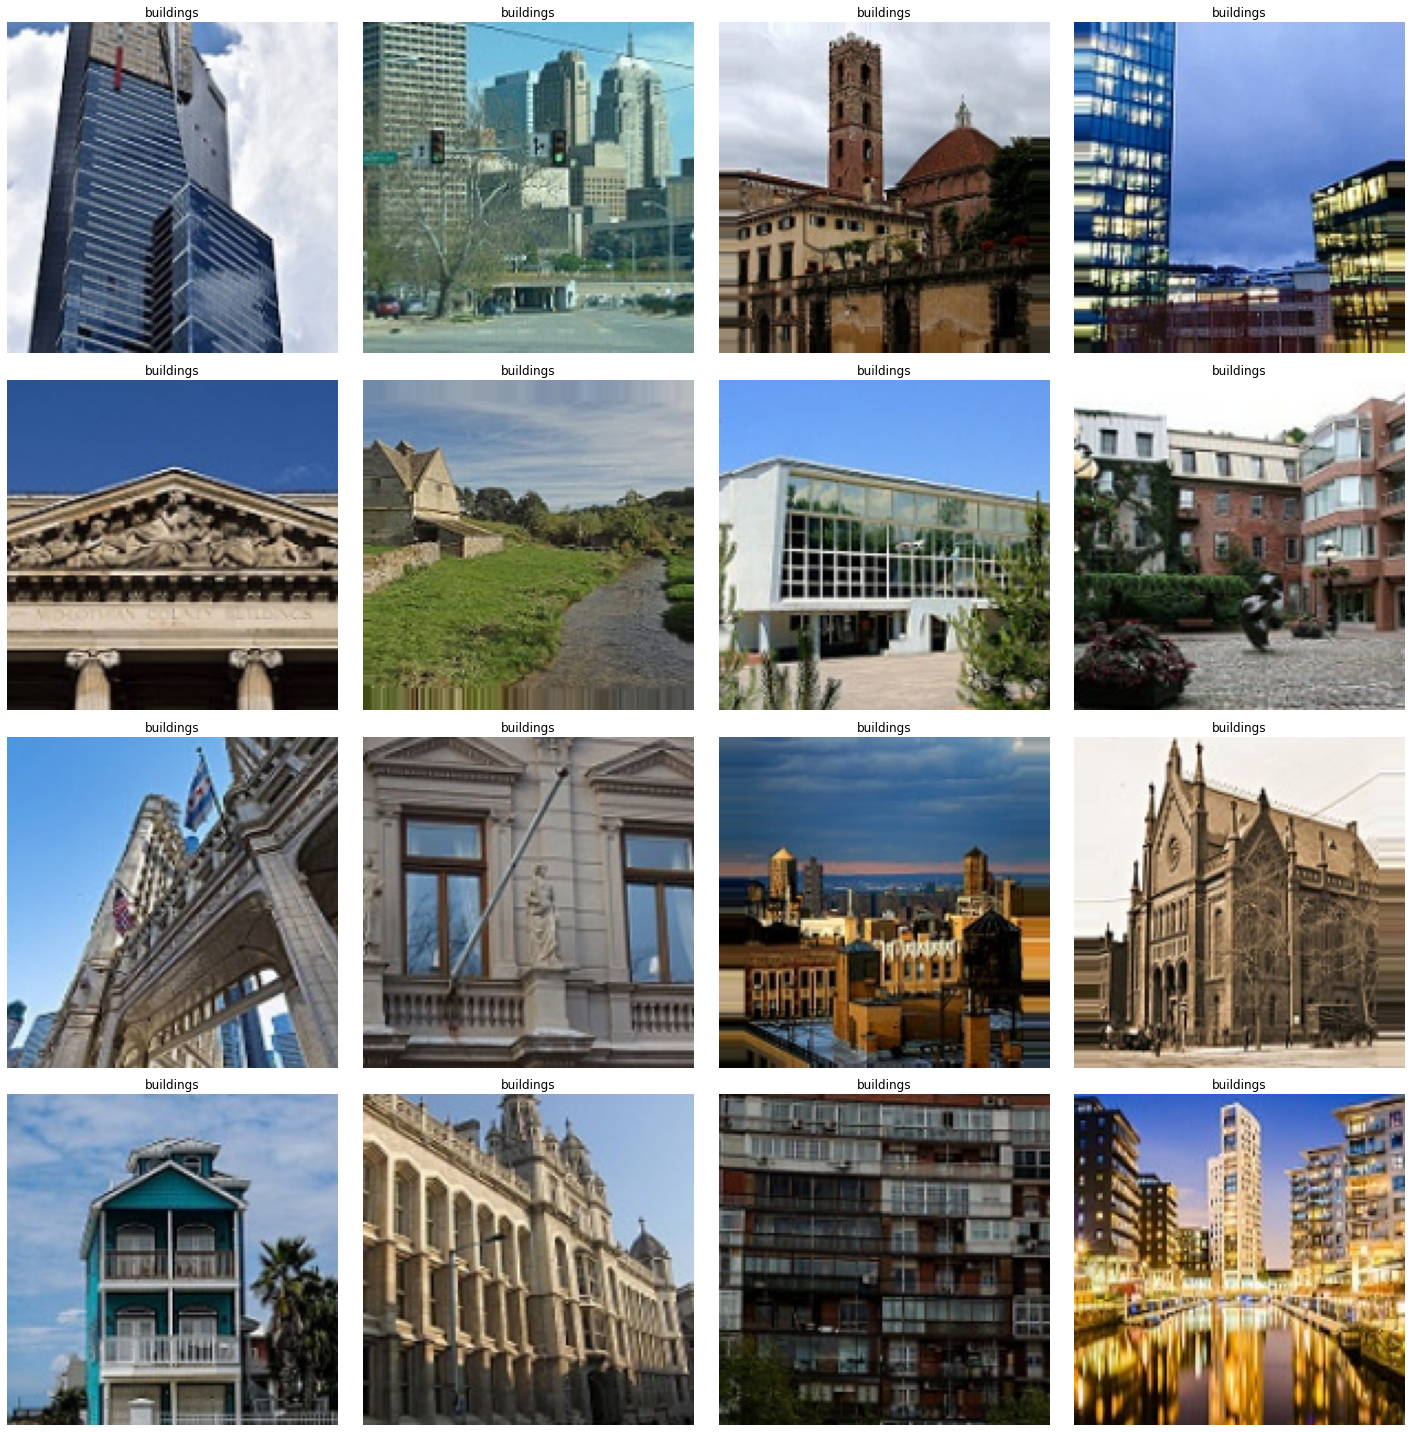

In [169]:
sample_test_images, labels = next(test_data_gen)
class_label = {v:k for k,v in test_data_gen.class_indices.items()}
fig, axes = plt.subplots(4, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_test_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

# define reducer

In [81]:
reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

# simple model

In [110]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6,activation='softmax')
])

In [89]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
flatten_6 (Flatten)          (None, 700928)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 4205574   
Total params: 4,206,470
Trainable params: 4,206,470
Non-trainable params: 0
_________________________________________________________________


In [120]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=1e-4,momentum=0.99),
    metrics=['accuracy']
)

history = model.fit(
    train_data_gen, 
    validation_data  = val_data_gen,
    epochs = 10, 
    verbose = 1,
    callbacks=[reduce]
)

Epoch 1/10
351/351 [==============================] - 53s 150ms/step - loss: 0.2228 - accuracy: 0.7111 - val_loss: 0.2359 - val_accuracy: 0.6972 - lr: 1.0000e-04
Epoch 2/10
351/351 [==============================] - 53s 151ms/step - loss: 0.2141 - accuracy: 0.7243 - val_loss: 0.2347 - val_accuracy: 0.7036 - lr: 1.0000e-04
Epoch 3/10
351/351 [==============================] - 53s 150ms/step - loss: 0.2129 - accuracy: 0.7307 - val_loss: 0.2370 - val_accuracy: 0.7008 - lr: 1.0000e-04
Epoch 4/10
351/351 [==============================] - 53s 150ms/step - loss: 0.2115 - accuracy: 0.7323 - val_loss: 0.2255 - val_accuracy: 0.7158 - lr: 1.0000e-04
Epoch 5/10
351/351 [==============================] - 53s 150ms/step - loss: 0.2087 - accuracy: 0.7392 - val_loss: 0.2267 - val_accuracy: 0.7111 - lr: 1.0000e-04
Epoch 6/10
351/351 [==============================] - 53s 150ms/step - loss: 0.2051 - accuracy: 0.7418 - val_loss: 0.2273 - val_accuracy: 0.7193 - lr: 1.0000e-04
Epoch 7/10
351/351 [========

In [121]:
model.evaluate(test_data_gen)

94/94 [==============================] - 11s 117ms/step - loss: 0.2299 - accuracy: 0.7170


[0.22986315190792084, 0.7170000076293945]

In [175]:
model.save('landscape_simple_model.h5')

In [122]:
model = tf.keras.models.load_model('landscape_simple_model.h5')

In [173]:
def plotAccuracy():
    epochs = [i for i in range(10)]
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    plt.plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

def plotLoss():
    epochs = [i for i in range(10)]
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    plt.plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    
def printConfusionMatrix():
    class_label = {v:k for k,v in test_data_gen.class_indices.items()}
    y_true = test_data_gen.classes
    predictions = model.predict(test_data_gen)
    y_pred = np.argmax(predictions, axis=-1)
    cm = confusion_matrix(y_true,y_pred)
    cm = pd.DataFrame(cm , index = [class_label[i] for i in range(6)] , columns = [class_label[i] for i in range(6)])
    print(cm)
    print()
    plt.figure(figsize = (6,6))
    g = sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
    g.set_yticklabels(g.get_yticklabels(), rotation = 45)

In [129]:
plotAccuracy()

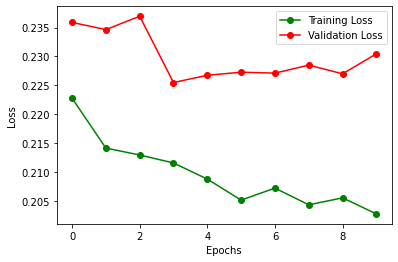

In [132]:
plotLoss()

           buildings  forest  glacier  mountain  sea  street
buildings        213      30       10        79   52      53
forest             8     414        2         7    2      41
glacier           10       6      201       130  194      12
mountain           8       4       22       385  103       3
sea               13      13       23        79  377       5
street            36      42        6        12   16     389



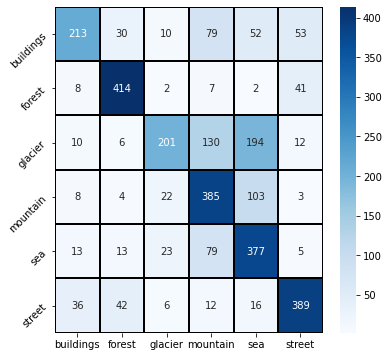

In [174]:
printConfusionMatrix()

# medium model

In [183]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.Conv2D(150,kernel_size=(3,3),activation='relu'),    
    tf.keras.layers.MaxPool2D(4,4),
    tf.keras.layers.Conv2D(50,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(4,4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(6,activation='softmax')
])

In [177]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 148, 148, 200)     5600      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 146, 146, 150)     270150    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 150)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 34, 34, 50)        67550     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 8, 50)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 3200)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 30)              

In [186]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    train_data_gen, 
    validation_data  = val_data_gen,
    epochs = 10, 
    verbose = 1,
    callbacks=[reduce]
)

Epoch 1/10
702/702 [==============================] - 169s 241ms/step - loss: 1.0092 - accuracy: 0.5990 - val_loss: 0.7869 - val_accuracy: 0.6990 - lr: 0.0010
Epoch 2/10
702/702 [==============================] - 169s 241ms/step - loss: 0.8873 - accuracy: 0.6652 - val_loss: 0.6902 - val_accuracy: 0.7657 - lr: 0.0010
Epoch 3/10
702/702 [==============================] - 169s 240ms/step - loss: 0.7947 - accuracy: 0.7033 - val_loss: 0.6844 - val_accuracy: 0.7507 - lr: 0.0010
Epoch 4/10
702/702 [==============================] - 169s 240ms/step - loss: 0.7408 - accuracy: 0.7305 - val_loss: 0.5518 - val_accuracy: 0.8074 - lr: 0.0010
Epoch 5/10
702/702 [==============================] - 169s 240ms/step - loss: 0.6876 - accuracy: 0.7524 - val_loss: 0.5226 - val_accuracy: 0.8135 - lr: 0.0010
Epoch 6/10
702/702 [==============================] - 168s 240ms/step - loss: 0.6536 - accuracy: 0.7647 - val_loss: 0.5183 - val_accuracy: 0.8124 - lr: 0.0010
Epoch 7/10
702/702 [==========================

In [187]:
model.evaluate(test_data_gen)

94/94 [==============================] - 16s 171ms/step - loss: 0.4539 - accuracy: 0.8523


[0.4539252817630768, 0.8523333072662354]

In [188]:
model.save('landscape_medium_model.h5')

In [189]:
model = tf.keras.models.load_model('landscape_medium_model.h5')

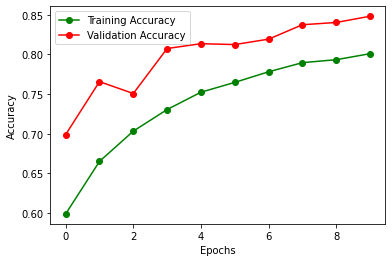

In [190]:
plotAccuracy()

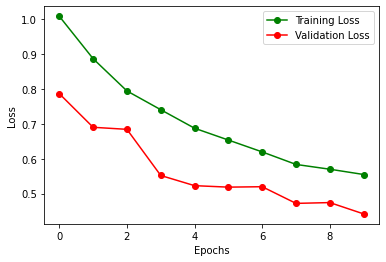

In [191]:
plotLoss()

           buildings  forest  glacier  mountain  sea  street
buildings        330       4        2        11   16      74
forest             0     463        1         5    0       5
glacier            1       3      429        72   44       4
mountain           4       1       53       400   64       3
sea                4       2       16        20  461       7
street            27       5        5         2   10     452



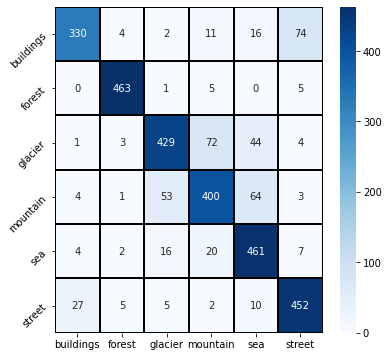

In [192]:
printConfusionMatrix()

# advanced model

In [193]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)),
        tf.keras.layers.Conv2D(150,kernel_size=(3,3),activation='relu'),
        tf.keras.layers.MaxPool2D(4,4),
        tf.keras.layers.Conv2D(120,kernel_size=(3,3),activation='relu'),    
        tf.keras.layers.Conv2D(80,kernel_size=(3,3),activation='relu'),    
        tf.keras.layers.Conv2D(50,kernel_size=(3,3),activation='relu'),
        tf.keras.layers.MaxPool2D(4,4),
        tf.keras.layers.Flatten(),    
        tf.keras.layers.Dense(120,activation='relu') ,    
        tf.keras.layers.Dense(100,activation='relu') ,    
        tf.keras.layers.Dense(50,activation='relu') ,        
        tf.keras.layers.Dropout(rate=0.5) ,            
        tf.keras.layers.Dense(6,activation='softmax') ,   
])

In [194]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 148, 148, 200)     5600      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 146, 146, 150)     270150    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 36, 36, 150)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 34, 34, 120)       162120    
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 80)        86480     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 30, 30, 50)        36050     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 50)        

In [195]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    train_data_gen, 
    validation_data  = val_data_gen,
    epochs = 10, 
    verbose = 1,
    callbacks=[reduce]
)

Epoch 1/10
702/702 [==============================] - 174s 248ms/step - loss: 1.3092 - accuracy: 0.4597 - val_loss: 1.0882 - val_accuracy: 0.5578 - lr: 0.0010
Epoch 2/10
702/702 [==============================] - 174s 247ms/step - loss: 0.9932 - accuracy: 0.6208 - val_loss: 0.8451 - val_accuracy: 0.6708 - lr: 0.0010
Epoch 3/10
702/702 [==============================] - 174s 247ms/step - loss: 0.8874 - accuracy: 0.6621 - val_loss: 0.7678 - val_accuracy: 0.7044 - lr: 0.0010
Epoch 4/10
702/702 [==============================] - 173s 247ms/step - loss: 0.7964 - accuracy: 0.7110 - val_loss: 0.6813 - val_accuracy: 0.7507 - lr: 0.0010
Epoch 5/10
702/702 [==============================] - 174s 247ms/step - loss: 0.7234 - accuracy: 0.7460 - val_loss: 0.6383 - val_accuracy: 0.7682 - lr: 0.0010
Epoch 6/10
702/702 [==============================] - 173s 247ms/step - loss: 0.6609 - accuracy: 0.7671 - val_loss: 0.6874 - val_accuracy: 0.7475 - lr: 0.0010
Epoch 7/10
702/702 [==========================

In [196]:
model.evaluate(test_data_gen)

94/94 [==============================] - 17s 176ms/step - loss: 0.4936 - accuracy: 0.8263


[0.4935714900493622, 0.8263333439826965]

In [197]:
model.save('landscape_advanced_model.h5')

In [198]:
model = tf.keras.models.load_model('landscape_advanced_model.h5')

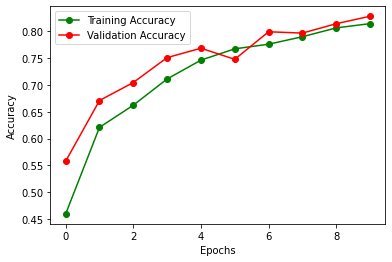

In [199]:
plotAccuracy()

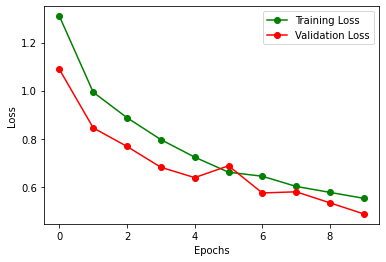

In [200]:
plotLoss()

           buildings  forest  glacier  mountain  sea  street
buildings        352       3        3         6    9      64
forest             1     444        2         6    0      21
glacier            2       2      445        76   19       9
mountain           7       1       61       416   34       6
sea               15       4       48        52  385       6
street            36       8        3         3    2     449



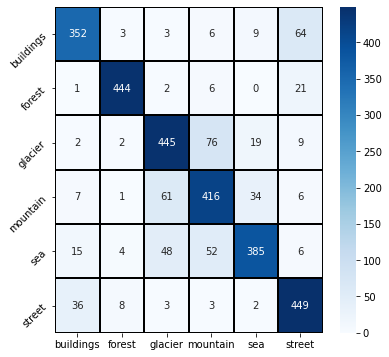

In [201]:
printConfusionMatrix()